In [18]:
import nltk
from nltk.corpus import treebank
import sklearn_crfsuite

# Ensure you have the necessary corpora downloaded
nltk.download('treebank')

### Functions for Feature Extraction:

def extract_features(sentence, index):
    word = sentence[index]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word.length()': len(word)
    }

    if index > 0:
        prev_word = sentence[index - 1]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True

    if index < len(sentence) - 1:
        next_word = sentence[index + 1]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def extract_features_from_sentence(sentence):
    return [extract_features(sentence, i) for i in range(len(sentence))]

### Load and Prepare Training Data:

train_data = treebank.tagged_sents()
X_train = [extract_features_from_sentence([word for word, tag in sentence]) for sentence in train_data]
Y_train = [[tag for word, tag in sentence] for sentence in train_data]

### Load Test Data from Input File:

def load_test_data(file_name):
    with open(file_name, 'r') as f:
        sentences = []
        sentence = []
        for line in f:
            if line.strip() == "":
                sentences.append(sentence)
                sentence = []
            else:
                sentence.append(line.strip())
        if sentence:
            sentences.append(sentence)
    return sentences

test_sentences = load_test_data('MISNO_Assign3_Input.txt')
X_test = [extract_features_from_sentence(sentence) for sentence in test_sentences]

### Train the CRF Model:

crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
crf.fit(X_train, Y_train)

### Predict on Test Data:

Y_pred = crf.predict(X_test)

### Save Results:

def save_results(file_name, sentences, labels):
    with open(file_name, 'w') as f:
        for sentence, label_seq in zip(sentences, labels):
            for word, label in zip(sentence, label_seq):
                f.write(f"{word}\t{label}\n")
            f.write("\n")

save_results('MISNO_Assign3_Output.txt', test_sentences, Y_pred)

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [6]:
!pip install sklearn_crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 16.5 MB/s eta 0:00:00


In [19]:
def extract_features(sentence, index, use_features):
    word = sentence[index]
    features = {}

    if 'bias' in use_features:
        features['bias'] = 1.0
    if 'word.lower()' in use_features:
        features['word.lower()'] = word.lower()
    if 'word[-3:]' in use_features:
        features['word[-3:]'] = word[-3:]
    if 'word.istitle()' in use_features:
        features['word.istitle()'] = word.istitle()
    if 'word.isdigit()' in use_features:
        features['word.isdigit()'] = word.isdigit()

    if index > 0:
        prev_word = sentence[index - 1]
        if '-1:word.lower()' in use_features:
            features['-1:word.lower()'] = prev_word.lower()
        if '-1:word.istitle()' in use_features:
            features['-1:word.istitle()'] = prev_word.istitle()
    else:
        features['BOS'] = True

    if index < len(sentence) - 1:
        next_word = sentence[index + 1]
        if '+1:word.lower()' in use_features:
            features['+1:word.lower()'] = next_word.lower()
        if '+1:word.istitle()' in use_features:
            features['+1:word.istitle()'] = next_word.istitle()
    else:
        features['EOS'] = True

    return features

In [20]:
def extract_features_from_sentence(sentence, use_features):
    return [extract_features(sentence, i, use_features) for i in range(len(sentence))]

In [21]:
def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [22]:
from sklearn.metrics import f1_score
import sklearn_crfsuite
import nltk
nltk.download('treebank')

# Load the Penn Treebank corpus and split into training and test sets
train_data = treebank.tagged_sents()[:-100]
test_data = treebank.tagged_sents()[-100:]

# Extract test sentences and true labels
test_sentences = [[word for word, tag in sentence] for sentence in test_data]
Y_true = [[tag for word, tag in sentence] for sentence in test_data]

def train_evaluate(features):
    X_train_feat = [extract_features_from_sentence([word for word, tag in sentence], features) for sentence in train_data]
    X_test_feat = [extract_features_from_sentence(sentence, features) for sentence in test_sentences]

    crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
    crf.fit(X_train_feat, Y_train)

    Y_pred = crf.predict(X_test_feat)

    # Flatten Y_pred and Y_true
    Y_pred_flat = flatten_list_of_lists(Y_pred)
    Y_true_flat = flatten_list_of_lists(Y_true)  # Ensure Y_true is defined

    score = f1_score(Y_true_flat, Y_pred_flat, average='micro')  # Adjust average parameter if needed

    return score


[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [23]:
all_features = ['bias', 'word.lower()', 'word[-3:]', 'word.istitle()', 'word.isdigit()', '-1:word.lower()', '-1:word.istitle()', '+1:word.lower()', '+1:word.istitle()']
results = {}

for feature in all_features:
    features_without_current = [f for f in all_features if f != feature]
    score = train_evaluate(features_without_current)
    results[feature] = score

In [24]:
results_incremental = {}
current_features = []

for feature in all_features:
    current_features.append(feature)
    score = train_evaluate(current_features)
    results_incremental[feature] = score

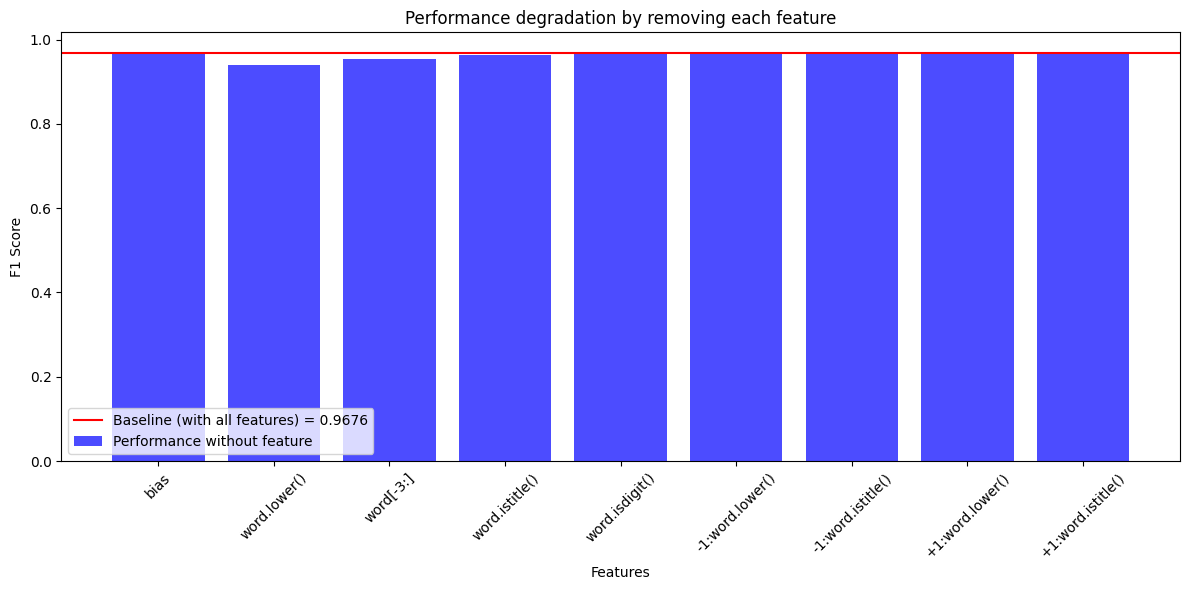

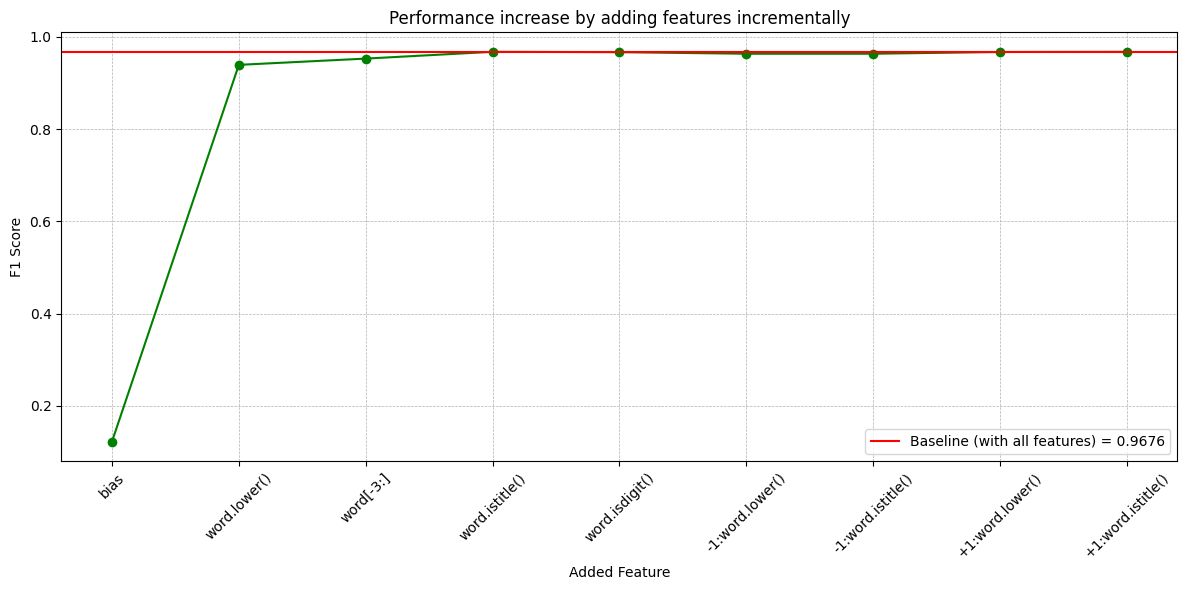

In [25]:
import matplotlib.pyplot as plt

# Assuming all_features and the CRF's predict method provides the true labels for test_data.
baseline_score = train_evaluate(all_features)

# Feature Ablation Study
feature_names = list(results.keys())
feature_scores = list(results.values())

plt.figure(figsize=(12,6))
plt.bar(feature_names, feature_scores, color='blue', alpha=0.7, label='Performance without feature')
plt.axhline(y=baseline_score, color='r', linestyle='-', label=f'Baseline (with all features) = {baseline_score:.4f}')
plt.xlabel('Features')
plt.ylabel('F1 Score')
plt.title('Performance degradation by removing each feature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Incremental Feature Addition
incremental_names = list(results_incremental.keys())
incremental_scores = list(results_incremental.values())

plt.figure(figsize=(12,6))
plt.plot(incremental_names, incremental_scores, marker='o', linestyle='-', color='green')
plt.axhline(y=baseline_score, color='r', linestyle='-', label=f'Baseline (with all features) = {baseline_score:.4f}')
plt.xlabel('Added Feature')
plt.ylabel('F1 Score')
plt.title('Performance increase by adding features incrementally')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [26]:
def print_example(index, feature_sets):
    sentence = test_sentences[index]
    print("Sentence:", " ".join(sentence))
    for feature_set in feature_sets:
        X = [extract_features_from_sentence(sentence, feature_set)]
        Y_pred = crf.predict(X)
        print(f"Predicted tags with features {feature_set}:", Y_pred[0])
    print("\n")

# Check results on a few sentences for different feature sets
example_indices = [0, 5, 10]  # Indices of sentences you want to examine
feature_sets_to_check = [all_features, all_features[:-2], all_features[:4]]  # Change as desired

for idx in example_indices:
    print_example(idx, feature_sets_to_check)

Sentence: The Army Corps is cutting the flow of the Missouri River about two weeks earlier than normal because of low water levels in the reservoirs that *T*-1 feed it .
Predicted tags with features ['bias', 'word.lower()', 'word[-3:]', 'word.istitle()', 'word.isdigit()', '-1:word.lower()', '-1:word.istitle()', '+1:word.lower()', '+1:word.istitle()']: ['DT', 'NNP', 'NNP', 'VBZ', 'VBG', 'DT', 'NN', 'IN', 'DT', 'NNP', 'NNP', 'IN', 'CD', 'NNS', 'JJR', 'IN', 'NN', 'IN', 'IN', 'JJ', 'NN', ':', 'IN', 'DT', 'NN', 'WDT', '-NONE-', 'VBP', 'PRP', '.']
Predicted tags with features ['bias', 'word.lower()', 'word[-3:]', 'word.istitle()', 'word.isdigit()', '-1:word.lower()', '-1:word.istitle()']: ['DT', 'NNP', 'NNP', 'VBZ', 'VBG', 'DT', 'NN', 'IN', 'DT', 'NNP', 'NNP', 'IN', 'CD', '.', 'RBR', 'IN', 'NN', 'IN', 'IN', 'JJ', 'NN', ':', 'IN', 'DT', 'NN', 'WDT', '-NONE-', 'VBP', 'PRP', '.']
Predicted tags with features ['bias', 'word.lower()', 'word[-3:]', 'word.istitle()']: ['DT', 'NNP', 'NNP', 'VBZ', 'R